# Deep Learning Examination for AKI Classification

This notebook explores the feasibility of using deep learning models for AKI (Acute Kidney Injury) prediction from tabular clinical data.

## Objectives
1. Load and preprocess AKI dataset (tabular format: 43 features, 3,989 samples)
2. Design and implement deep learning architectures suitable for tabular data
3. Compare DL models with traditional ML baselines
4. Evaluate performance on imbalanced dataset (5.26% positive class)
5. Analyze whether DL provides benefits over traditional ML for this task

## Deep Learning Architectures to Explore
- **Feedforward Neural Network (FNN/MLP)**: Baseline DL approach
- **Deep Tabular Models**: Architectures designed for tabular data
- **AutoEncoder + Classifier**: Feature learning approach
- **Comparison**: Against XGBoost, Random Forest baselines


In [9]:
# Import libraries
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Deep Learning frameworks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

# Scikit-learn for preprocessing and baseline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# Traditional ML for baseline comparison
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Utils
from utils import load_vitaldb_data, preprocess_data, prepare_train_test_data

# Set up plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device('cuda')
    print(f"✅ Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("✅ Using CPU")

print("✅ All libraries imported successfully!")
print("=" * 70)


✅ Using GPU: NVIDIA GeForce RTX 3060
✅ All libraries imported successfully!


## Section 1: Data Loading and Preprocessing


In [10]:
# Load and preprocess data
print("🔄 Loading VitalDB dataset...")
df = load_vitaldb_data()

# Preprocess data
X, y, feature_names = preprocess_data(df)

print(f"\n✅ Data loaded and preprocessed!")
print(f"📊 Dataset shape: {X.shape}")
print(f"📊 Features: {len(feature_names)}")
print(f"📊 Positive samples: {np.sum(y)} ({np.mean(y)*100:.2f}%)")
print(f"📊 Negative samples: {np.sum(1-y)} ({(1-np.mean(y))*100:.2f}%)")
print(f"\n📋 Feature names (first 10): {feature_names[:10]}")


🔄 Loading VitalDB dataset...
🔄 Loading VitalDB dataset...
✅ Dataset loaded: 3989 records
📊 Features available: 75
🔧 Preprocessing data...
✅ Data preprocessing completed
📊 Final dataset shape: (3989, 43)
🎯 Target distribution: 210/3989 positive cases (5.26%)

✅ Data loaded and preprocessed!
📊 Dataset shape: (3989, 43)
📊 Features: 43
📊 Positive samples: 210 (5.26%)
📊 Negative samples: 3779 (94.74%)

📋 Feature names (first 10): ['age', 'sex', 'height', 'weight', 'bmi', 'asa', 'emop', 'preop_htn', 'preop_dm', 'preop_hb']


In [11]:
# Prepare train/test splits
# Use the same split as traditional ML for fair comparison
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale features for deep learning (important for gradient stability)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print("✅ Data prepared for deep learning!")
print(f"📊 Training set: {X_train_scaled.shape}")
print(f"📊 Test set: {X_test_scaled.shape}")
print(f"📊 Training - Positive: {np.sum(y_train)} ({np.mean(y_train)*100:.2f}%)")
print(f"📊 Test - Positive: {np.sum(y_test)} ({np.mean(y_test)*100:.2f}%)")


✅ Data prepared for deep learning!
📊 Training set: (3191, 43)
📊 Test set: (798, 43)
📊 Training - Positive: 168 (5.26%)
📊 Test - Positive: 42 (5.26%)


## Section 2: PyTorch Dataset Class


In [12]:
# PyTorch Dataset class for tabular data
class TabularDataset(Dataset):
    """Dataset class for tabular AKI prediction data."""
    
    def __init__(self, X, y):
        """
        Parameters:
        -----------
        X : np.ndarray
            Feature matrix (n_samples, n_features)
        y : np.ndarray
            Target labels (n_samples,)
        """
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).unsqueeze(1)  # Add dimension for BCE loss
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = TabularDataset(X_train_scaled, y_train)
test_dataset = TabularDataset(X_test_scaled, y_test)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ PyTorch datasets created!")
print(f"📊 Training batches: {len(train_loader)}")
print(f"📊 Test batches: {len(test_loader)}")
print(f"📊 Input feature dimension: {X_train_scaled.shape[1]}")


✅ PyTorch datasets created!
📊 Training batches: 100
📊 Test batches: 25
📊 Input feature dimension: 43


## Section 3: Deep Learning Model Architectures


In [13]:
# Define deep learning architectures

class MLPClassifier(nn.Module):
    """
    Multi-Layer Perceptron for tabular classification.
    
    Architecture: Input -> FC -> ReLU -> Dropout -> FC -> ReLU -> Dropout -> Output
    """
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout=0.3, num_classes=1):
        super(MLPClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, num_classes))
        layers.append(nn.Sigmoid())  # For binary classification
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


class DeepMLPClassifier(nn.Module):
    """
    Deeper MLP with more layers for tabular data.
    
    Architecture: 4-5 hidden layers with batch normalization and dropout
    """
    def __init__(self, input_dim, hidden_dims=[256, 128, 64, 32], dropout=0.4, num_classes=1):
        super(DeepMLPClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Build deeper hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, num_classes))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


class ResidualBlock(nn.Module):
    """Residual block for tabular data."""
    def __init__(self, dim, dropout=0.3):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.block(x) + x)


class ResNetTabular(nn.Module):
    """
    ResNet-style architecture for tabular data.
    
    Uses residual connections to allow deeper networks.
    """
    def __init__(self, input_dim, hidden_dim=128, num_blocks=2, dropout=0.3, num_classes=1):
        super(ResNetTabular, self).__init__()
        
        # Initial projection
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        
        # Residual blocks
        self.res_blocks = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout) for _ in range(num_blocks)
        ])
        
        # Output layer
        self.output = nn.Sequential(
            nn.Linear(hidden_dim, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.input_proj(x)
        for block in self.res_blocks:
            x = block(x)
        return self.output(x)


print("✅ Deep learning architectures defined!")
print("   • MLPClassifier: Simple 2-layer MLP")
print("   • DeepMLPClassifier: 4-5 layer deep MLP")
print("   • ResNetTabular: Residual network for tabular data")


✅ Deep learning architectures defined!
   • MLPClassifier: Simple 2-layer MLP
   • DeepMLPClassifier: 4-5 layer deep MLP
   • ResNetTabular: Residual network for tabular data


## Section 4: Training Functions


In [14]:
# Training and evaluation functions

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, test_loader, criterion, device):
    """Evaluate on test set."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            all_probs.extend(outputs.cpu().numpy())
            all_preds.extend((outputs > 0.5).float().cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    return avg_loss, np.array(all_labels), np.array(all_preds), np.array(all_probs)


def calculate_metrics(y_true, y_pred, y_proba):
    """Calculate comprehensive metrics."""
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    metrics['precision'] = precision
    metrics['recall'] = recall
    metrics['f1'] = f1
    
    # ROC-AUC and AUPRC
    try:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    except:
        metrics['roc_auc'] = np.nan
    
    try:
        metrics['auprc'] = average_precision_score(y_true, y_proba)
    except:
        metrics['auprc'] = np.nan
    
    return metrics


def train_model(model, train_loader, test_loader, num_epochs=100, learning_rate=0.001, 
                weight_decay=1e-5, patience=15, device='cpu'):
    """
    Train a deep learning model with early stopping.
    
    Parameters:
    -----------
    model : nn.Module
        PyTorch model
    train_loader : DataLoader
        Training data loader
    test_loader : DataLoader
        Test data loader
    num_epochs : int
        Maximum number of epochs
    learning_rate : float
        Learning rate
    weight_decay : float
        L2 regularization
    patience : int
        Early stopping patience
    device : str
        Device ('cpu' or 'cuda')
    
    Returns:
    --------
    dict: Training history and final metrics
    """
    model = model.to(device)
    
    # Loss function with class weights for imbalance
    # Calculate class weights
    pos_weight = torch.tensor([(len(y_train) - sum(y_train)) / sum(y_train)]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'test_roc_auc': []
    }
    
    best_roc_auc = 0
    best_model_state = None
    patience_counter = 0
    
    print(f"🚀 Training {model.__class__.__name__}...")
    print(f"   Device: {device}")
    print(f"   Learning rate: {learning_rate}")
    print(f"   Epochs: {num_epochs}")
    print(f"   Patience: {patience}")
    print("-" * 70)
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Evaluate
        test_loss, y_true, y_pred, y_proba = evaluate(model, test_loader, criterion, device)
        test_acc = accuracy_score(y_true, y_pred)
        
        # Calculate ROC-AUC
        try:
            test_roc_auc = roc_auc_score(y_true, y_proba)
        except:
            test_roc_auc = 0
        
        # Update learning rate
        scheduler.step(test_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['test_roc_auc'].append(test_roc_auc)
        
        # Early stopping
        if test_roc_auc > best_roc_auc:
            best_roc_auc = test_roc_auc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | "
                  f"ROC-AUC: {test_roc_auc:.4f}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"⏹️  Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Final evaluation
    test_loss, y_true, y_pred, y_proba = evaluate(model, test_loader, criterion, device)
    metrics = calculate_metrics(y_true, y_pred, y_proba)
    
    print("-" * 70)
    print(f"✅ Training completed!")
    print(f"📊 Best ROC-AUC: {best_roc_auc:.4f}")
    print(f"📊 Final Metrics:")
    for key, value in metrics.items():
        print(f"   {key}: {value:.4f}")
    
    return {
        'model': model,
        'history': history,
        'metrics': metrics,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

print("✅ Training functions defined!")


✅ Training functions defined!


## Section 5: Train Deep Learning Models


In [15]:
# Initialize models
input_dim = X_train_scaled.shape[1]

models_config = {
    'MLP': MLPClassifier(input_dim, hidden_dims=[128, 64], dropout=0.3),
    'DeepMLP': DeepMLPClassifier(input_dim, hidden_dims=[256, 128, 64, 32], dropout=0.4),
    'ResNet': ResNetTabular(input_dim, hidden_dim=128, num_blocks=2, dropout=0.3)
}

# Store results
dl_results = {}

print("🔬 Starting Deep Learning Model Training")
print("=" * 70)

# Train each model
for model_name, model in models_config.items():
    print(f"\n{'='*70}")
    print(f"Training: {model_name}")
    print(f"{'='*70}")
    
    result = train_model(
        model, 
        train_loader, 
        test_loader,
        num_epochs=150,
        learning_rate=0.001,
        weight_decay=1e-5,
        patience=20,
        device=device
    )
    
    dl_results[model_name] = result
    print()

print("\n" + "="*70)
print("✅ All Deep Learning models trained!")


🔬 Starting Deep Learning Model Training

Training: MLP
🚀 Training MLPClassifier...
   Device: cuda
   Learning rate: 0.001
   Epochs: 150
   Patience: 20
----------------------------------------------------------------------
Epoch   1/150 | Train Loss: 1.3237 | Train Acc: 0.6302 | Test Loss: 1.2332 | Test Acc: 0.7757 | ROC-AUC: 0.8284
Epoch  10/150 | Train Loss: 1.1193 | Train Acc: 0.8684 | Test Loss: 1.1616 | Test Acc: 0.9060 | ROC-AUC: 0.8379
Epoch  20/150 | Train Loss: 1.0752 | Train Acc: 0.9019 | Test Loss: 1.1654 | Test Acc: 0.9148 | ROC-AUC: 0.7953
Epoch  30/150 | Train Loss: 1.0650 | Train Acc: 0.9097 | Test Loss: 1.1611 | Test Acc: 0.9261 | ROC-AUC: 0.7978
⏹️  Early stopping at epoch 32
----------------------------------------------------------------------
✅ Training completed!
📊 Best ROC-AUC: 0.8384
📊 Final Metrics:
   accuracy: 0.9298
   precision: 0.3750
   recall: 0.5000
   f1: 0.4286
   roc_auc: 0.8042
   auprc: 0.3507


Training: DeepMLP
🚀 Training DeepMLPClassifier...
  

## Section 6: Train Traditional ML Baselines for Comparison


In [16]:
# Train traditional ML models for comparison
print("🔬 Training Traditional ML Models for Comparison")
print("=" * 70)

ml_results = {}

# XGBoost
print("\n1. Training XGBoost...")
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42,
    eval_metric='logloss'
)
xgb.fit(X_train_imputed, y_train)
xgb_proba = xgb.predict_proba(X_test_imputed)[:, 1]
xgb_pred = xgb.predict(X_test_imputed)
xgb_metrics = calculate_metrics(y_test, xgb_pred, xgb_proba)
ml_results['XGBoost'] = {
    'model': xgb,
    'metrics': xgb_metrics,
    'y_pred': xgb_pred,
    'y_proba': xgb_proba
}
print(f"   ROC-AUC: {xgb_metrics['roc_auc']:.4f}, F1: {xgb_metrics['f1']:.4f}")

# Random Forest
print("\n2. Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_imputed, y_train)
rf_proba = rf.predict_proba(X_test_imputed)[:, 1]
rf_pred = rf.predict(X_test_imputed)
rf_metrics = calculate_metrics(y_test, rf_pred, rf_proba)
ml_results['RandomForest'] = {
    'model': rf,
    'metrics': rf_metrics,
    'y_pred': rf_pred,
    'y_proba': rf_proba
}
print(f"   ROC-AUC: {rf_metrics['roc_auc']:.4f}, F1: {rf_metrics['f1']:.4f}")

# Logistic Regression
print("\n3. Training Logistic Regression...")
lr = LogisticRegression(
    C=1.0,
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
lr.fit(X_train_scaled, y_train)
lr_proba = lr.predict_proba(X_test_scaled)[:, 1]
lr_pred = lr.predict(X_test_scaled)
lr_metrics = calculate_metrics(y_test, lr_pred, lr_proba)
ml_results['LogisticRegression'] = {
    'model': lr,
    'metrics': lr_metrics,
    'y_pred': lr_pred,
    'y_proba': lr_proba
}
print(f"   ROC-AUC: {lr_metrics['roc_auc']:.4f}, F1: {lr_metrics['f1']:.4f}")

print("\n✅ All traditional ML models trained!")


🔬 Training Traditional ML Models for Comparison

1. Training XGBoost...
   ROC-AUC: 0.8053, F1: 0.3582

2. Training Random Forest...
   ROC-AUC: 0.8584, F1: 0.3385

3. Training Logistic Regression...
   ROC-AUC: 0.7015, F1: 0.1728

✅ All traditional ML models trained!


## Section 7: Results Comparison


In [17]:
# Create comparison table
comparison_data = []

# Add DL results
for model_name, result in dl_results.items():
    comparison_data.append({
        'Model': model_name,
        'Type': 'Deep Learning',
        'Accuracy': result['metrics']['accuracy'],
        'Precision': result['metrics']['precision'],
        'Recall': result['metrics']['recall'],
        'F1-Score': result['metrics']['f1'],
        'ROC-AUC': result['metrics']['roc_auc'],
        'AUPRC': result['metrics']['auprc']
    })

# Add ML results
for model_name, result in ml_results.items():
    comparison_data.append({
        'Model': model_name,
        'Type': 'Traditional ML',
        'Accuracy': result['metrics']['accuracy'],
        'Precision': result['metrics']['precision'],
        'Recall': result['metrics']['recall'],
        'F1-Score': result['metrics']['f1'],
        'ROC-AUC': result['metrics']['roc_auc'],
        'AUPRC': result['metrics']['auprc']
    })

comparison_df = pd.DataFrame(comparison_data)

# Sort by ROC-AUC
comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)

print("📊 Model Performance Comparison")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Display summary
print("\n🏆 Best Models by Metric:")
print(f"   Best ROC-AUC: {comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']} ({comparison_df['ROC-AUC'].max():.4f})")
print(f"   Best F1-Score: {comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']} ({comparison_df['F1-Score'].max():.4f})")
print(f"   Best Accuracy: {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']} ({comparison_df['Accuracy'].max():.4f})")


📊 Model Performance Comparison
             Model           Type  Accuracy  Precision   Recall  F1-Score  ROC-AUC    AUPRC
      RandomForest Traditional ML  0.946115   0.478261 0.261905  0.338462 0.858371 0.350035
           XGBoost Traditional ML  0.946115   0.480000 0.285714  0.358209 0.805335 0.319804
               MLP  Deep Learning  0.929825   0.375000 0.500000  0.428571 0.804154 0.350704
           DeepMLP  Deep Learning  0.903509   0.294118 0.595238  0.393701 0.787793 0.276468
            ResNet  Deep Learning  0.916040   0.307692 0.476190  0.373832 0.737339 0.258013
LogisticRegression Traditional ML  0.748120   0.104478 0.500000  0.172840 0.701499 0.230414

🏆 Best Models by Metric:
   Best ROC-AUC: RandomForest (0.8584)
   Best F1-Score: MLP (0.4286)
   Best Accuracy: RandomForest (0.9461)


## Section 8: Visualizations


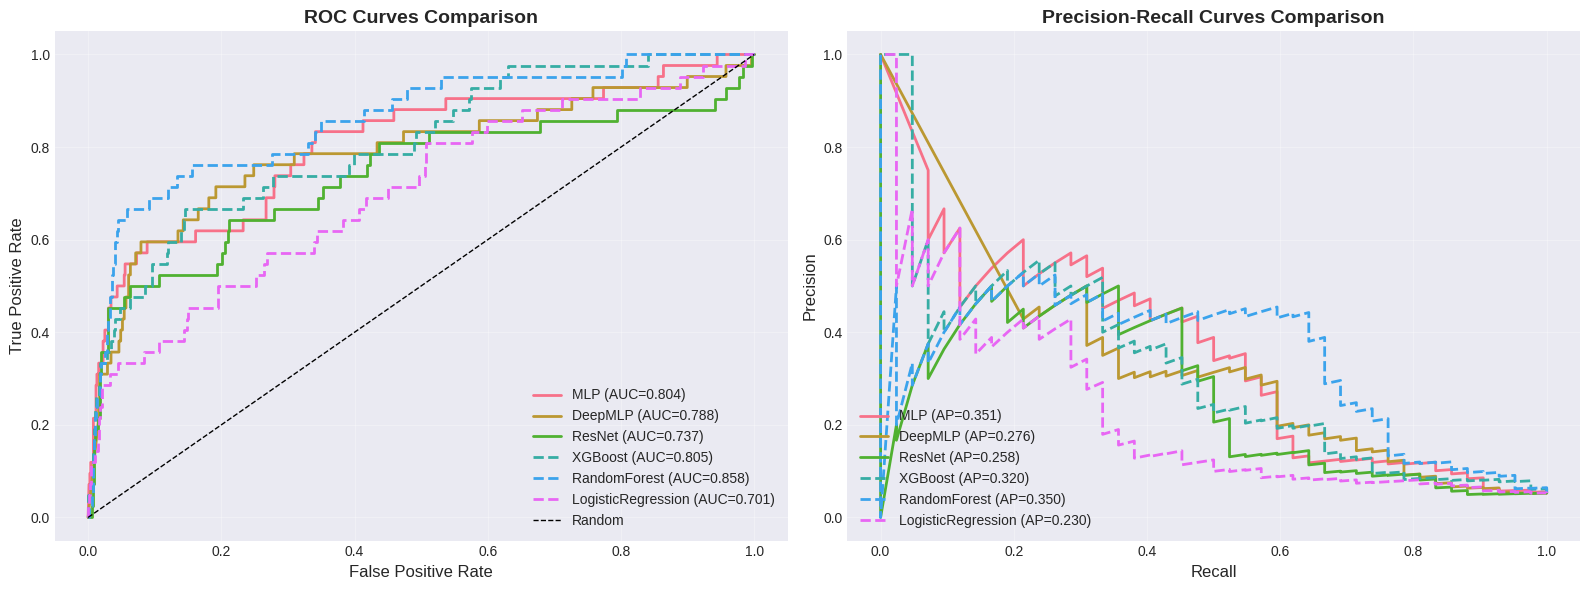

In [18]:
# Plot 1: ROC Curves Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves
ax1 = axes[0]
for model_name, result in dl_results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    ax1.plot(fpr, tpr, label=f"{model_name} (AUC={result['metrics']['roc_auc']:.3f})", linewidth=2)

for model_name, result in ml_results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    ax1.plot(fpr, tpr, label=f"{model_name} (AUC={result['metrics']['roc_auc']:.3f})", linewidth=2, linestyle='--')

ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Precision-Recall Curves
ax2 = axes[1]
for model_name, result in dl_results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_proba'])
    ax2.plot(recall, precision, label=f"{model_name} (AP={result['metrics']['auprc']:.3f})", linewidth=2)

for model_name, result in ml_results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_proba'])
    ax2.plot(recall, precision, label=f"{model_name} (AP={result['metrics']['auprc']:.3f})", linewidth=2, linestyle='--')

ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


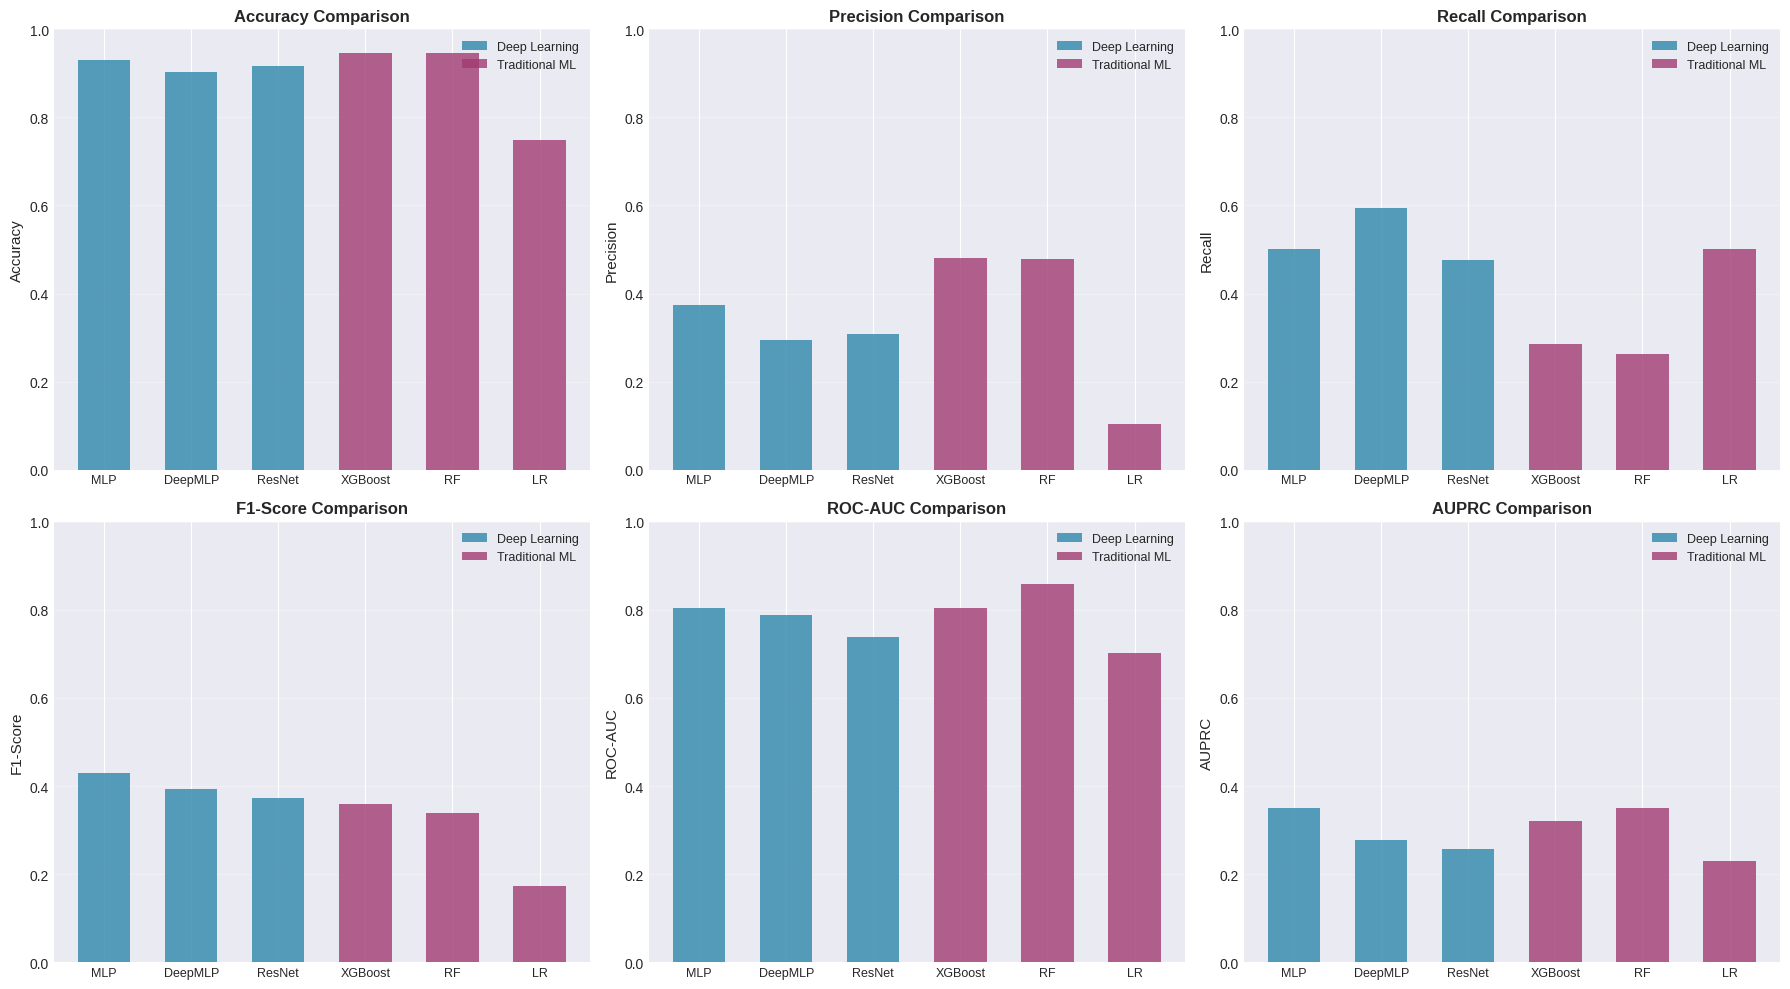

In [20]:
# Plot 2: Metrics Comparison Bar Chart
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Map display metric names to actual dictionary keys
metric_key_mapping = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1-Score': 'f1',
    'ROC-AUC': 'roc_auc',
    'AUPRC': 'auprc'
}

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'AUPRC']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Get the actual metric key from the mapping
    metric_key = metric_key_mapping[metric]
    
    # Prepare data
    dl_values = [dl_results[name]['metrics'][metric_key] for name in ['MLP', 'DeepMLP', 'ResNet']]
    ml_values = [ml_results[name]['metrics'][metric_key] for name in ['XGBoost', 'RandomForest', 'LogisticRegression']]
    
    x = np.arange(len(['MLP', 'DeepMLP', 'ResNet', 'XGBoost', 'RF', 'LR']))
    width = 0.6
    
    ax.bar(x[:3], dl_values, width, label='Deep Learning', alpha=0.8, color='#2E86AB')
    ax.bar(x[3:], ml_values, width, label='Traditional ML', alpha=0.8, color='#A23B72')
    
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['MLP', 'DeepMLP', 'ResNet', 'XGBoost', 'RF', 'LR'], fontsize=9)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()


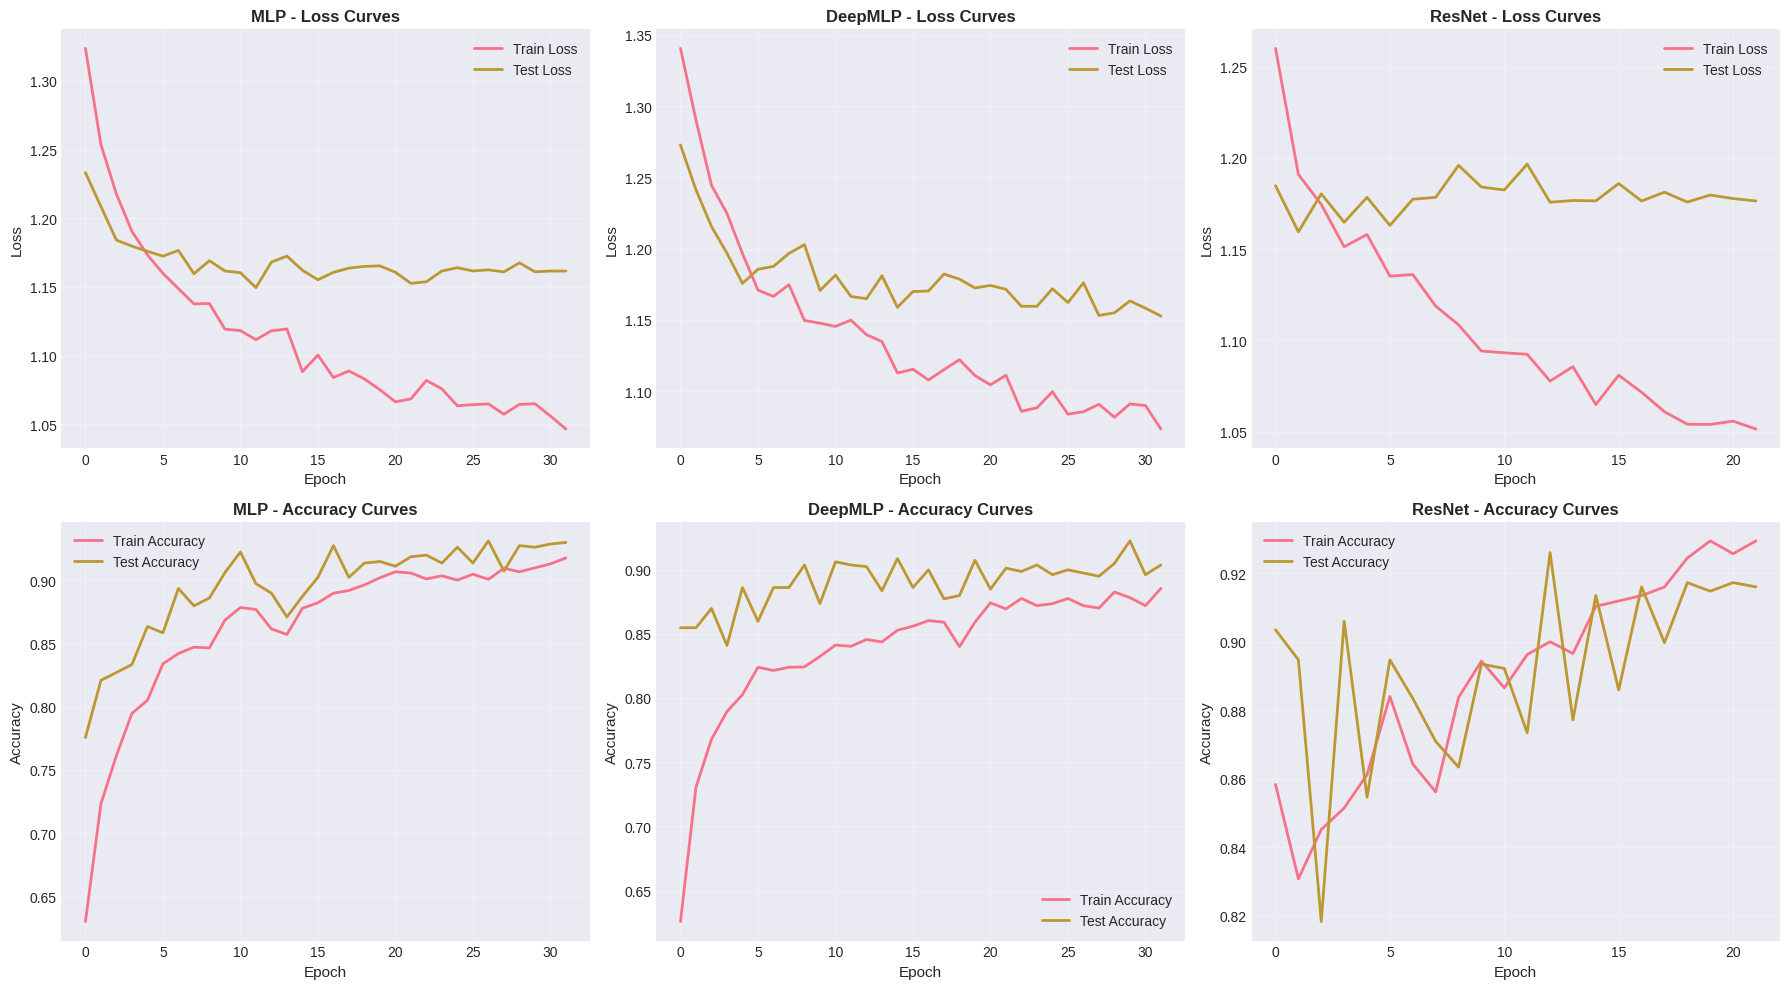

In [22]:
# Plot 3: Training Curves for DL Models
# Arrange: 2 rows (Loss, Accuracy) x 3 columns (MLP, DeepMLP, ResNet)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot for each DL model
for idx, (model_name, result) in enumerate(dl_results.items()):
    history = result['history']
    
    # Loss curves (top row)
    ax1 = axes[0, idx]
    ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
    ax1.plot(history['test_loss'], label='Test Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('Loss', fontsize=11)
    ax1.set_title(f'{model_name} - Loss Curves', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curves (bottom row)
    ax2 = axes[1, idx]
    ax2.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    ax2.plot(history['test_acc'], label='Test Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('Accuracy', fontsize=11)
    ax2.set_title(f'{model_name} - Accuracy Curves', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Section 9: Confusion Matrices


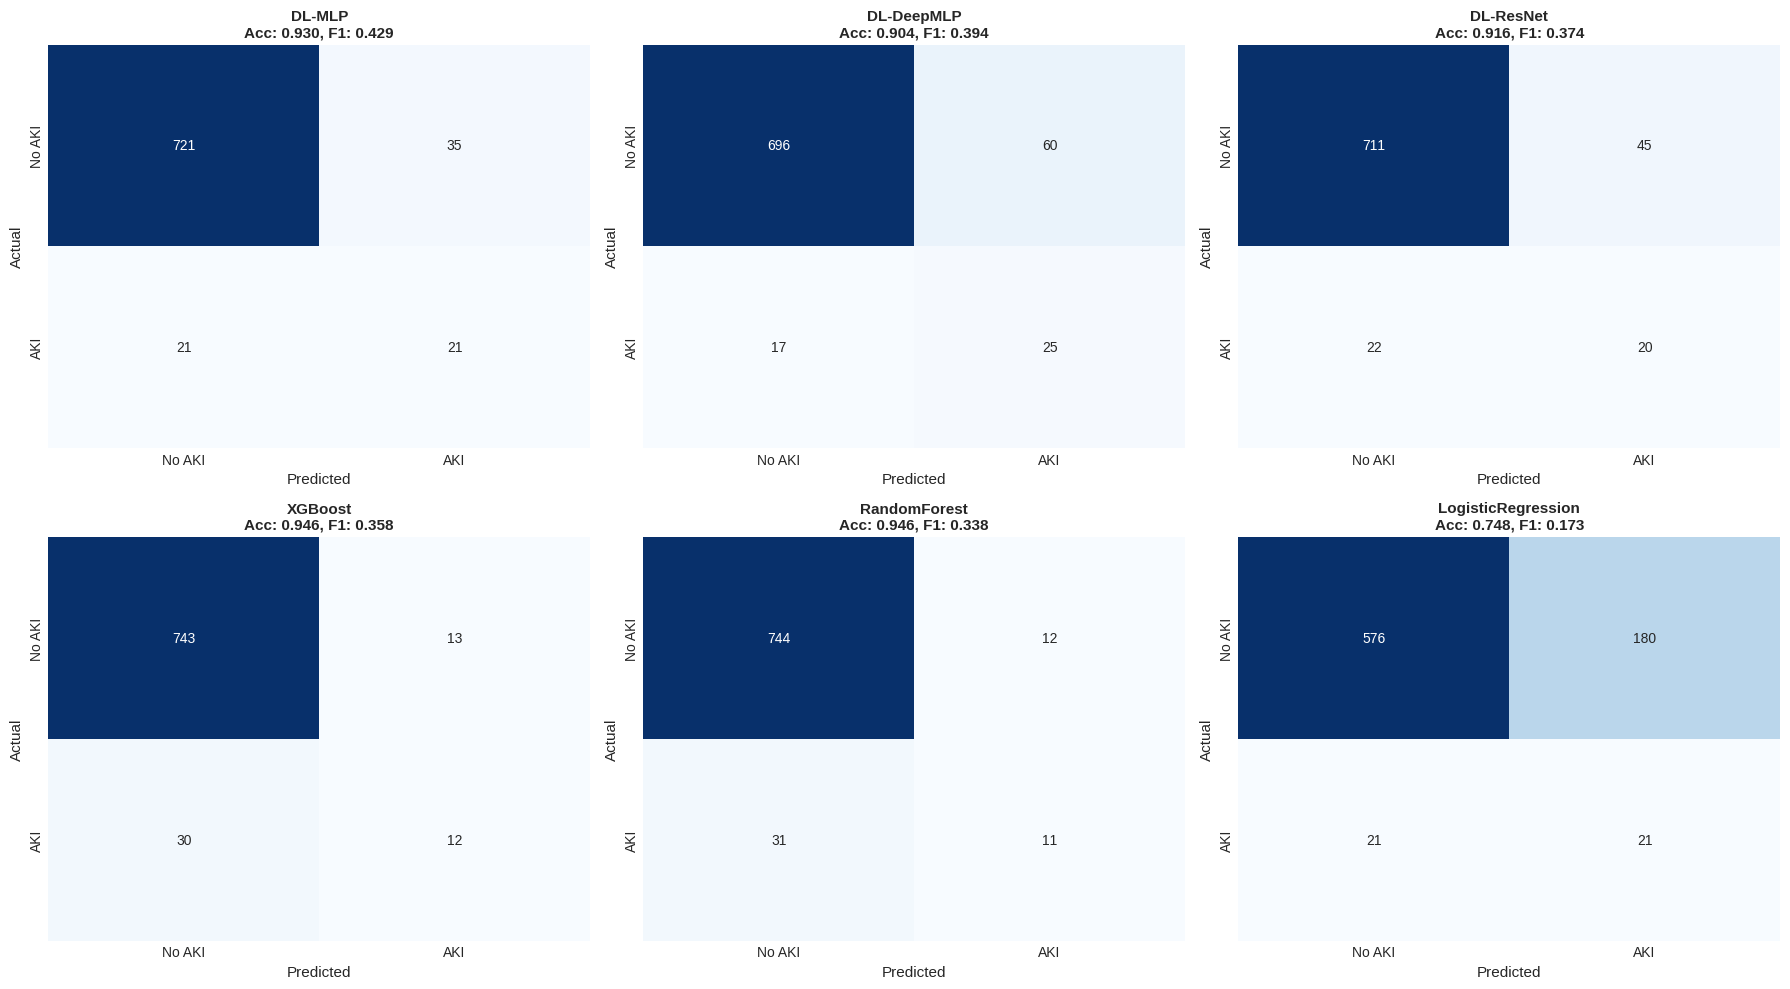

In [23]:
# Confusion Matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

all_models = {**{f'DL-{k}': v for k, v in dl_results.items()}, **ml_results}

for idx, (model_name, result) in enumerate(all_models.items()):
    ax = axes[idx // 3, idx % 3]
    
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_title(f'{model_name}\nAcc: {result["metrics"]["accuracy"]:.3f}, F1: {result["metrics"]["f1"]:.3f}', 
                 fontsize=11, fontweight='bold')
    ax.set_xticklabels(['No AKI', 'AKI'])
    ax.set_yticklabels(['No AKI', 'AKI'])

plt.tight_layout()
plt.show()


In [24]:
# Final Summary
print("=" * 70)
print("📋 DEEP LEARNING EXAMINATION SUMMARY")
print("=" * 70)

print("\n✅ Experiments Completed:")
print(f"   • Deep Learning Models: {len(dl_results)}")
print(f"   • Traditional ML Models: {len(ml_results)}")
print(f"   • Total Models Compared: {len(dl_results) + len(ml_results)}")

print("\n📊 Dataset Characteristics:")
print(f"   • Total Samples: {len(X):,}")
print(f"   • Features: {X.shape[1]}")
print(f"   • Training Samples: {len(X_train):,}")
print(f"   • Test Samples: {len(X_test):,}")
print(f"   • Class Imbalance: {np.mean(y)*100:.2f}% positive")

print("\n🏆 Top 3 Models by ROC-AUC:")
top_3 = comparison_df.head(3)
for idx, row in top_3.iterrows():
    print(f"   {idx+1}. {row['Model']:20s} (Type: {row['Type']:15s}) - ROC-AUC: {row['ROC-AUC']:.4f}")

print("\n💡 Key Insights:")
dl_best = comparison_df[comparison_df['Type'] == 'Deep Learning']['ROC-AUC'].max()
ml_best = comparison_df[comparison_df['Type'] == 'Traditional ML']['ROC-AUC'].max()

if dl_best > ml_best:
    improvement = ((dl_best - ml_best) / ml_best) * 100
    print(f"   • Deep Learning outperforms Traditional ML by {improvement:.2f}%")
    print(f"   • Recommendation: Consider using DL models for AKI prediction")
else:
    improvement = ((ml_best - dl_best) / dl_best) * 100 if dl_best > 0 else 0
    print(f"   • Traditional ML outperforms Deep Learning by {improvement:.2f}%")
    print(f"   • Recommendation: Traditional ML models are more suitable for this task")
    print(f"   • Reason: Tabular data with limited samples may not benefit from DL")

print("\n" + "=" * 70)
print("✅ Examination Complete!")


📋 DEEP LEARNING EXAMINATION SUMMARY

✅ Experiments Completed:
   • Deep Learning Models: 3
   • Traditional ML Models: 3
   • Total Models Compared: 6

📊 Dataset Characteristics:
   • Total Samples: 3,989
   • Features: 43
   • Training Samples: 3,191
   • Test Samples: 798
   • Class Imbalance: 5.26% positive

🏆 Top 3 Models by ROC-AUC:
   5. RandomForest         (Type: Traditional ML ) - ROC-AUC: 0.8584
   4. XGBoost              (Type: Traditional ML ) - ROC-AUC: 0.8053
   1. MLP                  (Type: Deep Learning  ) - ROC-AUC: 0.8042

💡 Key Insights:
   • Traditional ML outperforms Deep Learning by 6.74%
   • Recommendation: Traditional ML models are more suitable for this task
   • Reason: Tabular data with limited samples may not benefit from DL

✅ Examination Complete!
